In [1]:
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
import numpy as np
import libfmp.c3
import librosa
from numba import jit, njit
import scipy.spatial.distance as dist
from scipy.io import wavfile
import IPython.display as ipyd
import scipy.spatial.distance as dist

# DTW in audio:
Primeiro vamos exportar alguns arquivos .wav e plotar o Spectograma na escala logaritmica:

In [2]:
Karajan = "audios/karajan.wav"
karajan, f_karajan = librosa.load(Karajan)
ipyd.display(ipyd.Audio(karajan, rate=f_karajan))

In [3]:
Prom = "audios/Prom.wav"
prom, f_prom = librosa.load(Prom)
ipyd.display(ipyd.Audio(prom, rate=f_prom))

In [4]:
@jit(nopython=True)
def f_pitch(p, pitch_ref=69, freq_ref=440.0):
    """"Calcula as frequências centrais de um tom (MIDI)"""
    return 2 ** ((p - pitch_ref) / 12) * freq_ref

@jit(nopython=True)
def pool_pitch(p, Fs, N, pitch_ref=69, freq_ref=440.0):
    """"Calcula o conjunto de frequências atribuídas a um determinado tom."""
    lower = f_pitch(p - 0.5, pitch_ref, freq_ref)
    upper = f_pitch(p + 0.5, pitch_ref, freq_ref)
    k = np.arange(N // 2 + 1)
    k_freq = k * Fs / N
    mask = np.logical_and(lower <= k_freq, k_freq < upper)
    return k[mask]

@jit(nopython=True)
def compute_spec_log_freq(Y, Fs, N):
    """"Calcula um espectrograma de frequência logarítmica."""
    Y_LF = np.zeros((128, Y.shape[1]))
    for p in range(128):
        k = pool_pitch(p, Fs, N)
        Y_LF[p, :] = Y[k, :].sum(axis=0)
    F_coef_pitch = np.arange(128)
    return Y_LF, F_coef_pitch

@jit(nopython=True)
def compute_chromagram(Y_LF):
    """Trasforma um espectograma na frequencia logarítimica para chronograma"""
    C = np.zeros((12, Y_LF.shape[1]))
    p = np.arange(128)
    for c in range(12):
        mask = (p % 12) == c
        C[c, :] = Y_LF[mask, :].sum(axis=0)
    return C

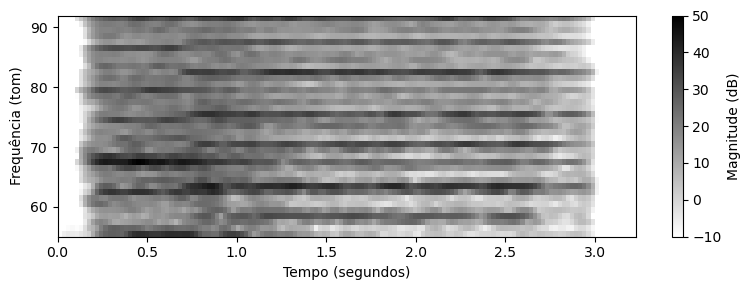

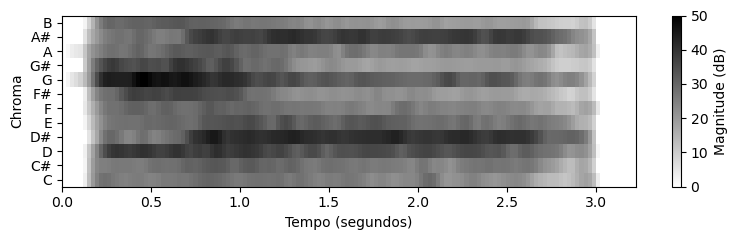

In [5]:
N = 4096
H = 512
X, T_coef, F_coef = libfmp.c2.stft_convention_fmp(karajan, f_karajan, N, H) #STFT
eps = np.finfo(float).eps
Y = np.abs(X) ** 2
Y_LF, F_coef_pitch = compute_spec_log_freq(Y, f_karajan, N)
C = compute_chromagram(Y_LF)

fig = plt.figure(figsize=(8,3))
chroma_label = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
plt.imshow(10 * np.log10(eps + Y_LF), origin='lower', aspect='auto', cmap='gray_r', 
           extent=[T_coef[0], T_coef[-1], 0, 128])
plt.clim([-10, 50])
plt.ylim([55, 92])
plt.xlabel('Tempo (segundos)')
plt.ylabel('Frequência (tom)')
cbar = plt.colorbar()
cbar.set_label('Magnitude (dB)')
plt.tight_layout()

fig = plt.figure(figsize=(8, 2.5))
plt.imshow(10 * np.log10(eps + C), origin='lower', aspect='auto', cmap='gray_r', 
           extent=[T_coef[0], T_coef[-1], 0, 12])
plt.clim([0, 50])
plt.xlabel('Tempo (segundos)')
plt.ylabel('Chroma')
cbar = plt.colorbar()
cbar.set_label('Magnitude (dB)')
plt.yticks(np.arange(12) + 0.5, chroma_label)
plt.tight_layout()

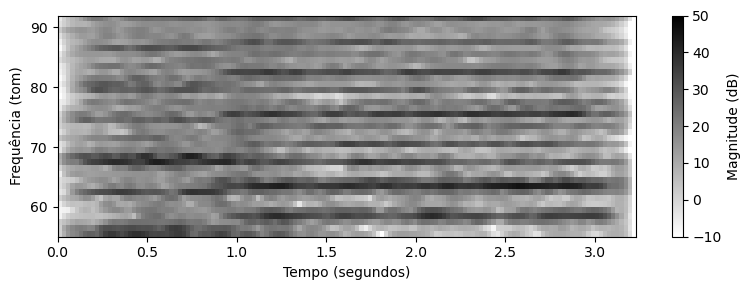

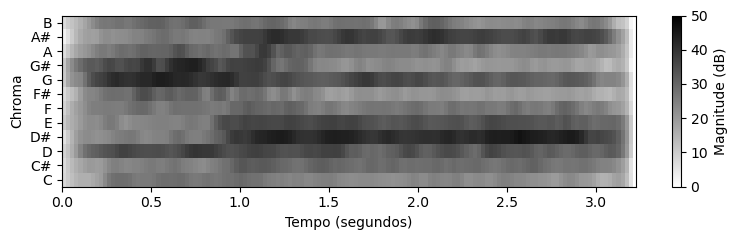

In [6]:
N = 4096
H = 512
X, T_coef, F_coef = libfmp.c2.stft_convention_fmp(prom, f_prom, N, H) #STFT
eps = np.finfo(float).eps
Y = np.abs(X) ** 2
Y_LF, F_coef_pitch = compute_spec_log_freq(Y, f_prom, N)
C = compute_chromagram(Y_LF)

fig = plt.figure(figsize=(8,3))
chroma_label = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
plt.imshow(10 * np.log10(eps + Y_LF), origin='lower', aspect='auto', cmap='gray_r', 
           extent=[T_coef[0], T_coef[-1], 0, 128])
plt.clim([-10, 50])
plt.ylim([55, 92])
plt.xlabel('Tempo (segundos)')
plt.ylabel('Frequência (tom)')
cbar = plt.colorbar()
cbar.set_label('Magnitude (dB)')
plt.tight_layout()

fig = plt.figure(figsize=(8, 2.5))
plt.imshow(10 * np.log10(eps + C), origin='lower', aspect='auto', cmap='gray_r', 
           extent=[T_coef[0], T_coef[-1], 0, 12])
plt.clim([0, 50])
plt.xlabel('Tempo (segundos)')
plt.ylabel('Chroma')
cbar = plt.colorbar()
cbar.set_label('Magnitude (dB)')
plt.yticks(np.arange(12) + 0.5, chroma_label)
plt.tight_layout()

# Chromagram da biblioteca libmp

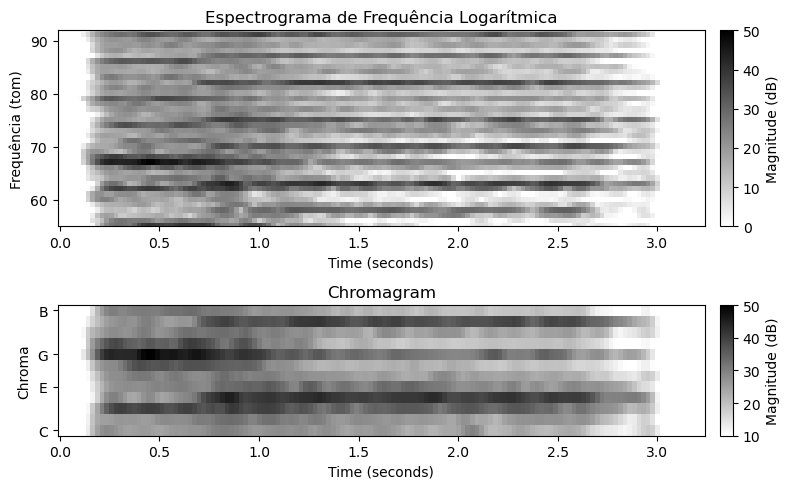

In [7]:
N, H = 4096, 512
X, T_coef, F_coef = libfmp.c2.stft_convention_fmp(karajan, f_karajan, N, H)
Y = np.abs(X) ** 2
Y_LF, F_coef_pitch = libfmp.c3.compute_spec_log_freq(Y, f_karajan, N)
C = libfmp.c3.compute_chromagram(Y_LF)

fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.02], 
                                          'height_ratios': [3, 2]}, figsize=(8, 5))  

libfmp.b.plot_matrix(10 * np.log10(eps + Y_LF), Fs = f_karajan/H, ax=[ax[0,0], ax[0,1]], 
        ylim=[55,92], clim=[0, 50], title='Espectrograma de Frequência Logarítmica', 
        ylabel='Frequência (tom)', colorbar=True, cbar_label='Magnitude (dB)');

libfmp.b.plot_chromagram(10 * np.log10(eps + C), Fs = f_karajan/H, ax=[ax[1,0], ax[1,1]],  
        chroma_yticks = [0,4,7,11], clim=[10, 50], title='Chromagram', 
        ylabel='Chroma', colorbar=True, cbar_label='Magnitude (dB)');

plt.tight_layout()

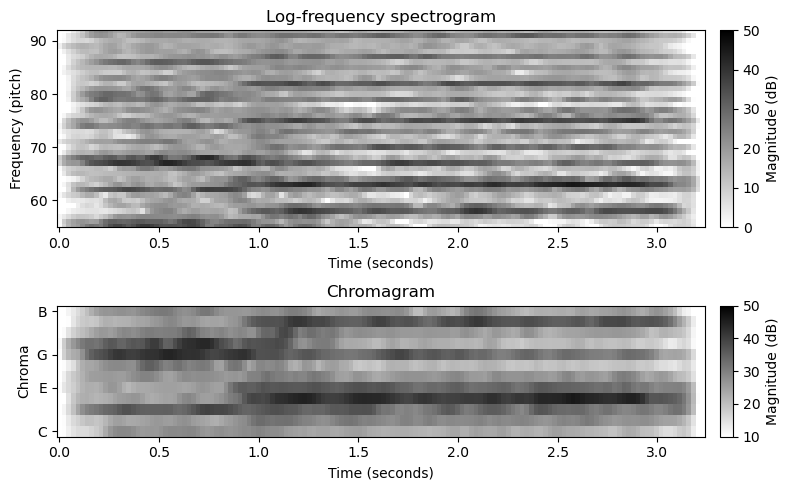

In [8]:
N, H = 4096, 512
X, T_coef, F_coef = libfmp.c2.stft_convention_fmp(prom, f_prom, N, H)
Y = np.abs(X) ** 2
Y_LF, F_coef_pitch = libfmp.c3.compute_spec_log_freq(Y, f_prom, N)
C = libfmp.c3.compute_chromagram(Y_LF)

fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.02], 
                                          'height_ratios': [3, 2]}, figsize=(8, 5))  

libfmp.b.plot_matrix(10 * np.log10(eps + Y_LF), Fs = f_prom/H, ax=[ax[0,0], ax[0,1]], 
        ylim=[55,92], clim=[0, 50], title='Log-frequency spectrogram', 
        ylabel='Frequency (pitch)', colorbar=True, cbar_label='Magnitude (dB)');

libfmp.b.plot_chromagram(10 * np.log10(eps + C), Fs = f_prom/H, ax=[ax[1,0], ax[1,1]],  
        chroma_yticks = [0,4,7,11], clim=[10, 50], title='Chromagram', 
        ylabel='Chroma', colorbar=True, cbar_label='Magnitude (dB)');

plt.tight_layout()

# calculando DTW entre os audios em croma:

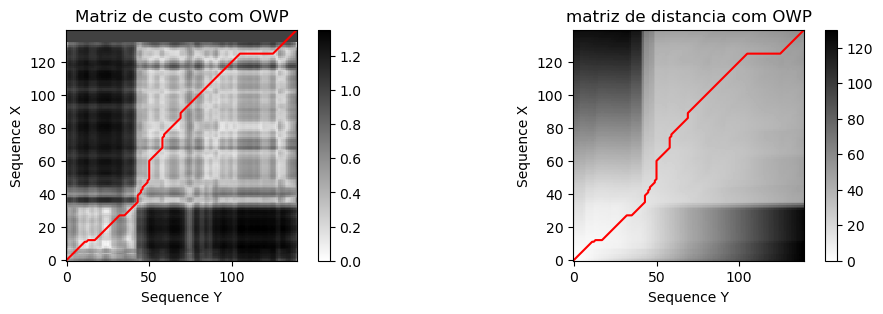

In [9]:
N, H = 4096, 512
X = librosa.feature.chroma_stft(y=karajan, sr=f_karajan, tuning=0, norm=2, hop_length=H, n_fft=N)
Y = librosa.feature.chroma_stft(y=prom, sr=f_prom, tuning=0, norm=2, hop_length=H, n_fft=N)

C = libfmp.c3.compute_cost_matrix(X, Y)
D = libfmp.c3.compute_accumulated_cost_matrix(C)
P = libfmp.c3.compute_optimal_warping_path(D)

plt.figure(figsize=(12, 3))
ax = plt.subplot(1, 2, 1)
libfmp.c3.plot_matrix_with_points(C, P, linestyle='-',  marker='', 
    ax=[ax], aspect='equal', clim=[0, np.max(C)], 
    title='Matriz de custo com OWP', xlabel='Sequence Y', ylabel='Sequence X');

ax = plt.subplot(1, 2, 2)
libfmp.c3.plot_matrix_with_points(D, P, linestyle='-', marker='', 
    ax=[ax], aspect='equal', clim=[0, np.max(D)], 
    title='matriz de distancia com OWP', xlabel='Sequence Y', ylabel='Sequence X');

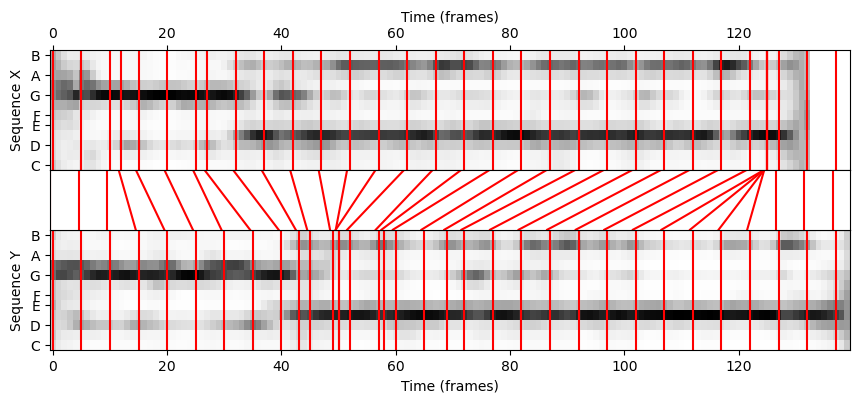

In [10]:
N = X.shape[1]
M = Y.shape[1]

plt.figure(figsize=(8, 3))
ax_X = plt.axes([0, 0.60, 1, 0.40])
librosa.display.specshow(X, ax=ax_X, x_axis='frames', y_axis='chroma', cmap='gray_r', hop_length=H)
ax_X.set_ylabel('Sequence X')
ax_X.set_xlabel('Time (frames)')
ax_X.xaxis.tick_top()
ax_X.xaxis.set_label_position('top') 

ax_Y = plt.axes([0, 0, 1, 0.40])
librosa.display.specshow(Y, ax=ax_Y, x_axis='frames', y_axis='chroma', cmap='gray_r', hop_length=H)
ax_Y.set_ylabel('Sequence Y')
ax_Y.set_xlabel('Time (frames)')

step = 5
y_min_X, y_max_X = ax_X.get_ylim()
y_min_Y, y_max_Y = ax_Y.get_ylim()
for t in P[0:-1:step, :]: 
    ax_X.vlines(t[0], y_min_X, y_max_X, color='r')
    ax_Y.vlines(t[1], y_min_Y, y_max_Y, color='r')

ax = plt.axes([0, 0.40, 1, 0.20])
for p in P[0:-1:step, :]: 
    ax.plot((p[0]/N, p[1]/M), (1, -1), color='r')
    ax.set_xlim(0, 1)
    ax.set_ylim(-1, 1)
ax.set_xticks([])
ax.set_yticks([]);


# Log-Mel spectrograma:

C:\Users\brand\AppData\Local\Temp\ipykernel_11420\4206183555.py:7: RuntimeWarning: divide by zero encountered in log
  log_mel_spec_x = np.log(mel_spec_x)


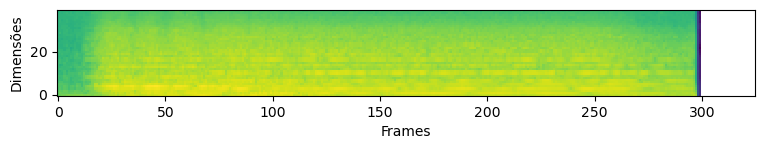

In [11]:
n_fft_x = int(0.025*f_karajan)      # 25 ms
hop_length_x = int(0.01*f_karajan)  # 10 ms
mel_spec_x = librosa.feature.melspectrogram(
    y=karajan, sr=f_karajan, n_mels=40,
    n_fft=n_fft_x, hop_length=hop_length_x
    )
log_mel_spec_x = np.log(mel_spec_x)
fig, ax = plt.subplots(figsize=(9, 5))
ax.imshow(log_mel_spec_x, origin="lower", interpolation="nearest");
plt.ylabel("Dimensões")
plt.xlabel("Frames");

C:\Users\brand\AppData\Local\Temp\ipykernel_11420\12815635.py:7: RuntimeWarning: divide by zero encountered in log
  log_mel_spec_y = np.log(mel_spec_y)


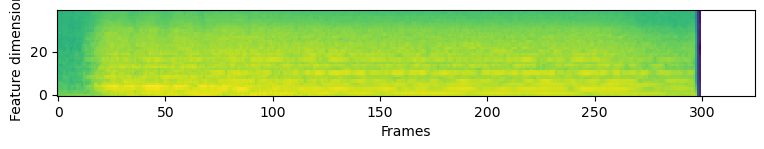

In [12]:
n_fft_y = int(0.025*f_prom)      # 25 ms
hop_length_y = int(0.01*f_prom)  # 10 ms
mel_spec_y = librosa.feature.melspectrogram(
    y=prom, sr=f_prom, n_mels=40,
    n_fft=n_fft_y, hop_length=hop_length_y
    )
log_mel_spec_y = np.log(mel_spec_y)
fig, ax = plt.subplots(figsize=(9, 5))
ax.imshow(log_mel_spec_x, origin="lower", interpolation="nearest");
plt.ylabel("Feature dimensions")
plt.xlabel("Frames");

# DTW em Log-Mel spectrograma:

In [13]:
@njit
def compute_i_custo_anterior(custo_anterior):
    i_custo_anterior = 0
    min_custo_anterior = custo_anterior[0]
    for k in range(1, 3):
        if custo_anterior[k] < min_custo_anterior:
            i_custo_anterior = k
            min_custo_anterior = custo_anterior[k]
    return i_custo_anterior

@jit(nopython=True)
def DTW_C(matriz_distancia):
    N, M = matriz_distancia.shape
    
    matriz_custo = np.zeros((N + 1, M + 1))
    for i in range(1, N + 1):
        matriz_custo[i, 0] = np.inf
    for i in range(1, M + 1):
        matriz_custo[0, i] = np.inf

    optimal_warping_path = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            custo_anterior = [
                matriz_custo[i, j],
                matriz_custo[i, j + 1],
                matriz_custo[i + 1, j]
            ]
            i_custo_anterior = compute_i_custo_anterior(custo_anterior)
            matriz_custo[i + 1, j + 1] = matriz_distancia[i, j] + custo_anterior[i_custo_anterior]
            optimal_warping_path[i, j] = i_custo_anterior

    i = N - 1
    j = M - 1
    caminho = [(i, j)]
    while i > 0 or j > 0:
        OWT_tipo = optimal_warping_path[i, j]
        if OWT_tipo == 0:
            i = i - 1
            j = j - 1
        elif OWT_tipo == 1:
            i = i - 1
        elif OWT_tipo == 2:
            j = j - 1
        caminho.append((i, j))

    matriz_custo = matriz_custo[1:, 1:]
    return (caminho[::-1], matriz_custo)

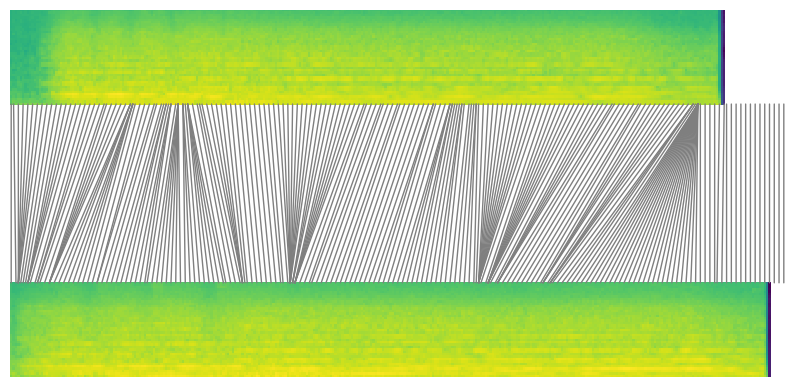

In [14]:
matriz_distancia = dist.cdist(mel_spec_x.T, mel_spec_y.T, "cosine")
caminho, matriz_custo = DTW_C(matriz_distancia)

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(313)
ax1.imshow(log_mel_spec_x, origin="lower", interpolation="nearest")
ax2.imshow(log_mel_spec_y, origin="lower", interpolation="nearest")
ax1.axis("off")
ax2.axis("off")
for idx, (x_i, y_j) in enumerate(caminho):
    if idx % 2 != 0:
        continue
    con = ConnectionPatch(
        xyA=(x_i, 0), xyB=(y_j, log_mel_spec_y.shape[0] - 1), coordsA="data", coordsB="data",
        axesA=ax1, axesB=ax2, color="C7"
    )
    ax2.add_artist(con)

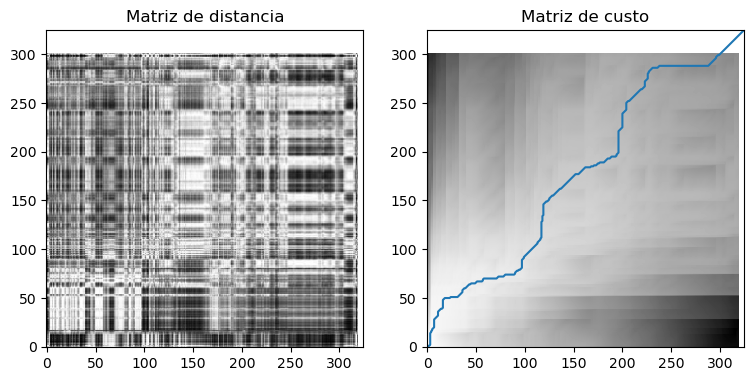

In [15]:
plt.figure(figsize=(9, 5))
plt.subplot(121)
plt.title("Matriz de distancia")
plt.imshow(matriz_distancia, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
plt.subplot(122)
plt.title("Matriz de custo")
plt.imshow(matriz_custo, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
x_path, y_path = zip(*caminho)
plt.plot(y_path, x_path);